In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

def preprocess_obesity_data(file_path):
    # 1. Load the data
    df = pd.read_csv(file_path)
    
    # 2. Check for missing values
    print("Missing values:\n", df.isnull().sum())
    
    # 3. Simple data validation
    # Remove any rows where height or weight are unreasonable
    df = df[(df['Height'] > 1.4) & (df['Height'] < 2.2) &
            (df['Weight'] > 40) & (df['Weight'] < 200)]
    
    # 4. Encode categorical variables using Label Encoder
    categorical_cols = ['Gender', 'family_history', 'FAVC', 'CAEC', 
                       'SMOKE', 'SCC', 'CALC', 'MTRANS']
    
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    
    # 5. Scale numerical variables (now without Weight)
    numerical_cols = ['Age', 'Height', 'FCVC', 'NCP', 
                     'CH2O', 'FAF', 'TUE']
    
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    
    # 6. Split features and target, dropping both BMI and Weight
    X = df.drop(['BMI', 'Weight'], axis=1)
    y = df['BMI']
    
    # 7. Print basic statistics
    print("\nDataset shape:", df.shape)
    print("\nFeature names:", list(X.columns))
    
    return X, y

In [2]:
x,y =preprocess_obesity_data("ObesityPrediction.csv")

Missing values:
 Gender            0
Age               0
Height            0
Weight            0
family_history    0
FAVC              0
FCVC              0
NCP               0
CAEC              0
SMOKE             0
CH2O              0
SCC               0
FAF               0
TUE               0
CALC              0
MTRANS            0
BMI               0
dtype: int64

Dataset shape: (2105, 17)

Feature names: ['Gender', 'Age', 'Height', 'family_history', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']


In [3]:
print(y)

0       24.386526
1       24.238227
2       23.765432
3       26.851852
4       28.342381
          ...    
2106    44.901475
2107    43.741923
2108    43.543817
2109    44.071535
2110    44.144338
Name: BMI, Length: 2105, dtype: float64


In [4]:
print(x)

      Gender       Age    Height  family_history  FAVC      FCVC       NCP  \
0          0 -0.524137 -0.882009               1     0 -0.793282  0.402928   
1          0 -0.524137 -1.956374               1     0  1.087496  0.402928   
2          1 -0.209058  1.051847               1     0 -0.793282  0.402928   
3          1  0.421101  1.051847               0     0  1.087496  0.402928   
4          1 -0.366598  0.836974               0     0 -0.793282 -2.168920   
...      ...       ...       ...             ...   ...       ...       ...   
2106       0 -0.527786  0.092762               1     1  1.087496  0.402928   
2107       0 -0.369285  0.499452               1     1  1.087496  0.402928   
2108       0 -0.284041  0.538365               1     1  1.087496  0.402928   
2109       0  0.005501  0.401319               1     1  1.087496  0.402928   
2110       0 -0.104340  0.394723               1     1  1.087496  0.402928   

      CAEC  SMOKE      CH2O  SCC       FAF       TUE  CALC  MTR

In [7]:
import torch
import torch.nn as nn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import pandas as pd


class FeatureEngineering:
    def __init__(self):
        self.poly = PolynomialFeatures(degree=2, include_bias=False)
        
    def create_interaction_terms(self, X):
        # Create polynomial and interaction features
        numerical_cols = ['Age', 'Height', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
        X_num = X[numerical_cols]
        
        # Generate polynomial features
        poly_features = self.poly.fit_transform(X_num)
        
        # Generate correct feature names
        feature_names = self.poly.get_feature_names_out(numerical_cols)
        
        # Create DataFrame with polynomial features
        X_poly = pd.DataFrame(
            poly_features,
            columns=feature_names,
            index=X.index
        )
        
        # Create custom ratios
        X_ratios = pd.DataFrame({
            'height_age_ratio': X['Height'] / X['Age'],
            'ch2o_faf_ratio': X['CH2O'] / (X['FAF'] + 1),  # Add 1 to avoid division by zero
            'ncp_fcvc_ratio': X['NCP'] / (X['FCVC'] + 1)
        }, index=X.index)
        
        # Drop the original features from X_poly since they're already in X
        X_poly = X_poly.drop(columns=numerical_cols)
        
        # Combine all features
        return pd.concat([X, X_poly, X_ratios], axis=1)

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        
    def forward(self, x):
        # Self attention
        attended, _ = self.attention(x, x, x)
        x = self.norm1(x + attended)
        
        # Feed forward
        fed_forward = self.feed_forward(x)
        return self.norm2(x + fed_forward)

class HybridBMIPredictor(nn.Module):
    def __init__(self, input_dim, embed_dim=128):
        super(HybridBMIPredictor, self).__init__()
        
        # Initial embedding
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, embed_dim),
            nn.GELU(),
            nn.LayerNorm(embed_dim)
        )
        
        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads=4)
            for _ in range(3)
        ])
        
        # Parallel convolutional branch
        self.conv_branch = nn.Sequential(
            nn.Linear(input_dim, embed_dim),
            nn.GELU(),
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, embed_dim // 2)
        )
        
        # Output layers
        self.output = nn.Sequential(
            nn.Linear(embed_dim + embed_dim // 2, embed_dim // 2),
            nn.GELU(),
            nn.LayerNorm(embed_dim // 2),
            nn.Linear(embed_dim // 2, 1)
        )
        
    def forward(self, x):
        # Transform input through transformer pathway
        trans_input = self.embedding(x).unsqueeze(0)
        for block in self.transformer_blocks:
            trans_input = block(trans_input)
        trans_output = trans_input.squeeze(0)
        
        # Process through convolutional pathway
        conv_output = self.conv_branch(x)
        
        # Combine pathways
        combined = torch.cat([trans_output, conv_output], dim=1)
        return self.output(combined)

class EnsemblePredictor:
    def __init__(self, input_dim, ensemble_size=5):
        self.neural_nets = [HybridBMIPredictor(input_dim) for _ in range(ensemble_size)]
        self.random_forest = RandomForestRegressor(
            n_estimators=100,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2
        )
        
    def train(self, X, y, epochs=100, batch_size=32):
        # Convert data to tensors
        X_tensor = torch.FloatTensor(X.values)
        y_tensor = torch.FloatTensor(y.values)
        
        # Train neural networks
        criterion = nn.HuberLoss(delta=1.0)
        
        for i, net in enumerate(self.neural_nets):
            print(f"Training neural network {i+1}/{len(self.neural_nets)}")
            optimizer = torch.optim.AdamW(net.parameters(), lr=0.001, weight_decay=0.01)
            
            for epoch in range(epochs):
                # Training loop
                net.train()
                for j in range(0, len(X), batch_size):
                    batch_X = X_tensor[j:j+batch_size]
                    batch_y = y_tensor[j:j+batch_size]
                    
                    optimizer.zero_grad()
                    outputs = net(batch_X)
                    loss = criterion(outputs, batch_y.unsqueeze(1))
                    loss.backward()
                    optimizer.step()
                
                if (epoch + 1) % 20 == 0:
                    print(f"Network {i+1}, Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
            
        # Train random forest
        print("Training random forest...")
        self.random_forest.fit(X, y)
        
    def predict(self, X):
        # Convert to tensor
        X_tensor = torch.FloatTensor(X.values)
        
        # Get predictions from all models
        nn_preds = []
        for net in self.neural_nets:
            net.eval()
            with torch.no_grad():
                pred = net(X_tensor)
                nn_preds.append(pred.numpy())
        
        rf_pred = self.random_forest.predict(X)
        
        # Weighted average of predictions
        nn_weight = 0.7
        rf_weight = 0.3
        
        final_pred = (
            nn_weight * np.mean(nn_preds, axis=0) +
            rf_weight * rf_pred.reshape(-1, 1)
        )
        
        return final_pred.flatten()

def train_enhanced_model(X, y):
    # Feature engineering
    print("Performing feature engineering...")
    feature_engineer = FeatureEngineering()
    X_enhanced = feature_engineer.create_interaction_terms(X)
    print(f"Enhanced feature space shape: {X_enhanced.shape}")
    
    # Create and train ensemble
    print("Training ensemble model...")
    ensemble = EnsemblePredictor(input_dim=X_enhanced.shape[1])
    ensemble.train(X_enhanced, y)
    
    return ensemble, feature_engineer

if __name__ == "__main__":
    # Split into train and test sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    # Train model
    model, feature_engineer = train_enhanced_model(X_train, y_train)


Performing feature engineering...
Enhanced feature space shape: (1684, 46)
Training ensemble model...
Training neural network 1/5
Network 1, Epoch [20/100], Loss: 0.7625
Network 1, Epoch [40/100], Loss: 0.3409
Network 1, Epoch [60/100], Loss: 0.2541
Network 1, Epoch [80/100], Loss: 0.2154
Network 1, Epoch [100/100], Loss: 0.0932
Training neural network 2/5
Network 2, Epoch [20/100], Loss: 0.5674
Network 2, Epoch [40/100], Loss: 0.1165
Network 2, Epoch [60/100], Loss: 0.0844
Network 2, Epoch [80/100], Loss: 0.0953
Network 2, Epoch [100/100], Loss: 0.0508
Training neural network 3/5
Network 3, Epoch [20/100], Loss: 0.6255
Network 3, Epoch [40/100], Loss: 0.4136
Network 3, Epoch [60/100], Loss: 0.2988
Network 3, Epoch [80/100], Loss: 0.1155
Network 3, Epoch [100/100], Loss: 0.1085
Training neural network 4/5
Network 4, Epoch [20/100], Loss: 1.0975
Network 4, Epoch [40/100], Loss: 0.6422
Network 4, Epoch [60/100], Loss: 0.1956
Network 4, Epoch [80/100], Loss: 0.0791
Network 4, Epoch [100/1


Test Set Evaluation:

Classification Report (Within 3.0 BMI points):
                   precision    recall  f1-score   support

Outside Threshold       0.00      0.00      0.00         0
 Within Threshold       1.00      0.82      0.90       421

         accuracy                           0.82       421
        macro avg       0.50      0.41      0.45       421
     weighted avg       1.00      0.82      0.90       421


Detailed Error Analysis:
Mean Absolute Error: 1.74 BMI points
Median Absolute Error: 0.90 BMI points
Standard Deviation of Error: 2.06 BMI points
90th percentile of absolute error: 4.68 BMI points
95th percentile of absolute error: 6.18 BMI points

Error Distribution:
Error 0-0.5 BMI points: 35.4%
Error 0.5-1 BMI points: 16.4%
Error 1-1.5 BMI points: 10.9%
Error 1.5-2 BMI points: 6.9%
Error 2-2.5 BMI points: 5.5%
Error 2.5-3 BMI points: 7.1%
Error 3+ BMI points: 17.8%


C:\Users\teddy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\teddy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\teddy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: Unde

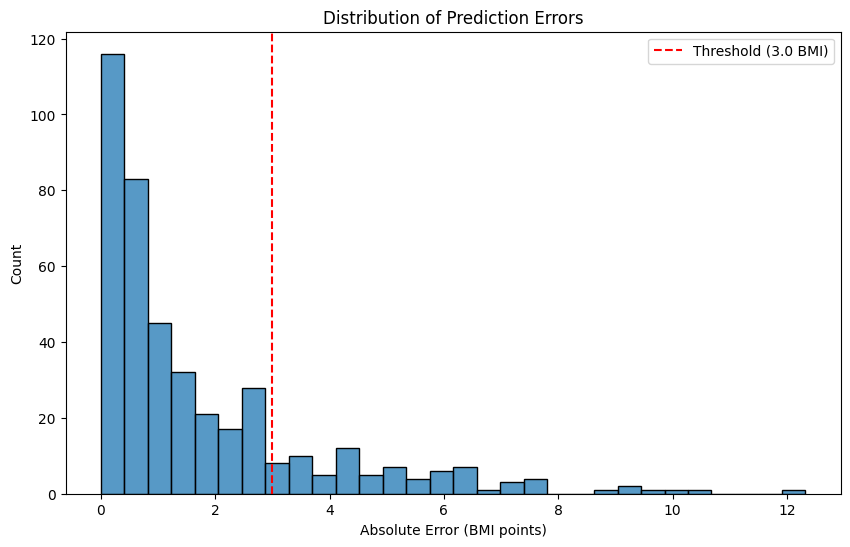

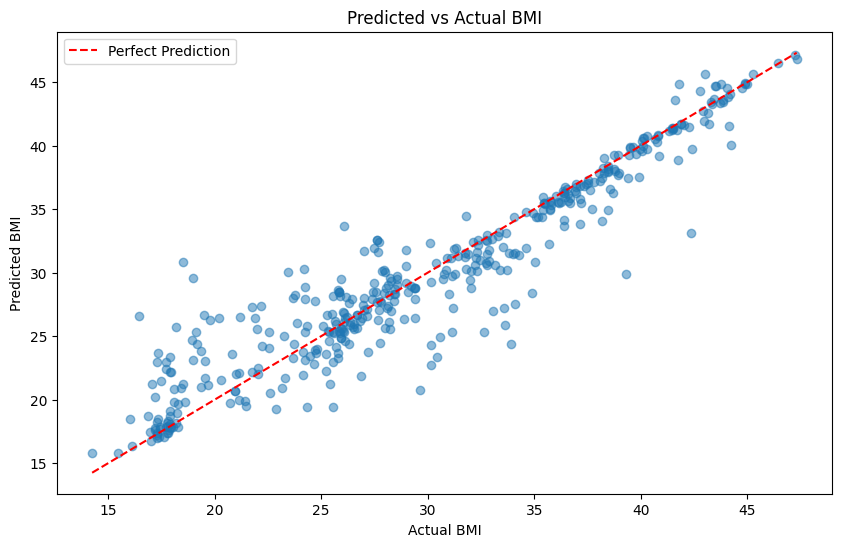


Training Set Evaluation:

Classification Report (Within 3.0 BMI points):
                   precision    recall  f1-score   support

Outside Threshold       0.00      0.00      0.00         0
 Within Threshold       1.00      0.99      0.99      1684

         accuracy                           0.99      1684
        macro avg       0.50      0.49      0.50      1684
     weighted avg       1.00      0.99      0.99      1684


Detailed Error Analysis:
Mean Absolute Error: 0.45 BMI points
Median Absolute Error: 0.28 BMI points
Standard Deviation of Error: 0.63 BMI points
90th percentile of absolute error: 0.95 BMI points
95th percentile of absolute error: 1.49 BMI points

Error Distribution:
Error 0-0.5 BMI points: 74.3%
Error 0.5-1 BMI points: 16.4%
Error 1-1.5 BMI points: 4.3%
Error 1.5-2 BMI points: 2.0%
Error 2-2.5 BMI points: 1.3%
Error 2.5-3 BMI points: 0.4%
Error 3+ BMI points: 1.2%


C:\Users\teddy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\teddy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\teddy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: Unde

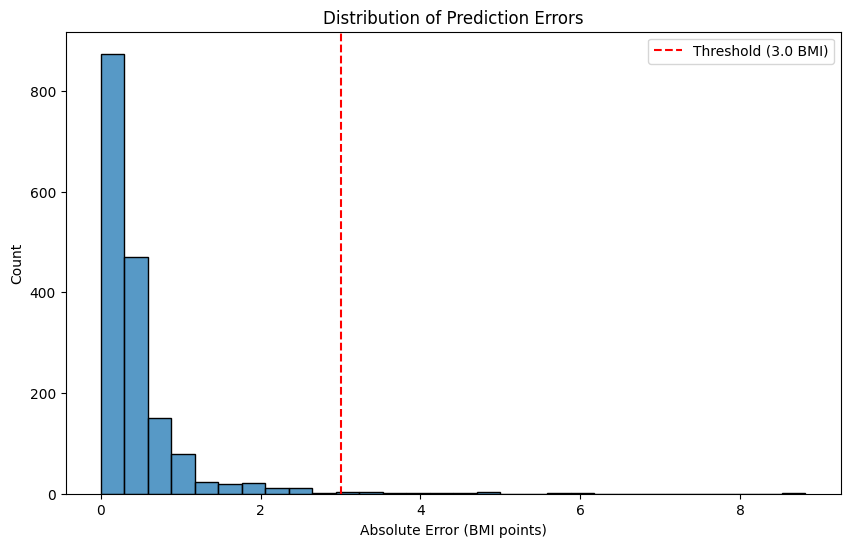

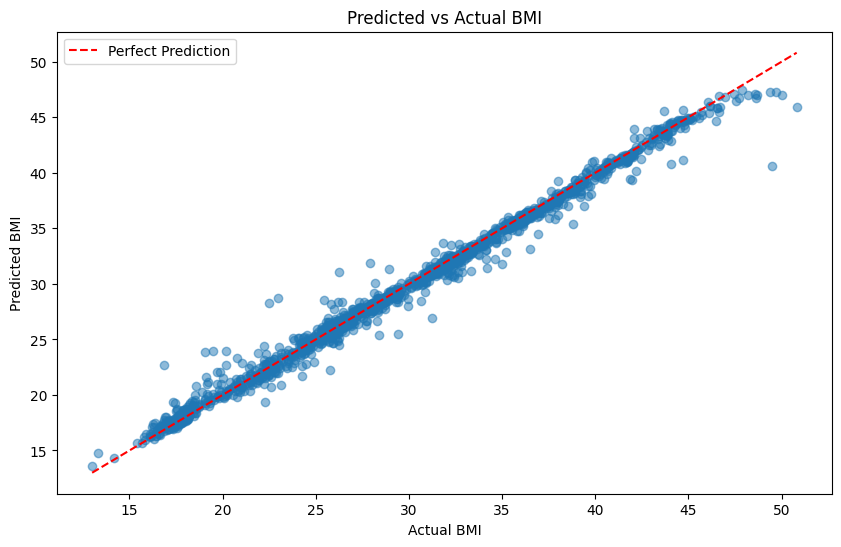

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_bmi_predictions(model, feature_engineer, X, y, threshold=3.0):
    """
    Generate comprehensive evaluation metrics for the BMI prediction model.
    """
    # Enhance features
    X_enhanced = feature_engineer.create_interaction_terms(X)
    
    # Get predictions
    predictions = model.predict(X_enhanced)
    
    # Calculate absolute errors
    errors = np.abs(y - predictions)
    
    # Create binary classifications based on threshold
    y_true_binary = np.ones_like(y)  # Target is always 1 (within threshold)
    y_pred_binary = (errors <= threshold).astype(int)
    
    # Generate classification report
    print("\nClassification Report (Within {} BMI points):".format(threshold))
    print(classification_report(y_true_binary, y_pred_binary, 
                              target_names=['Outside Threshold', 'Within Threshold']))
    
    # Calculate additional metrics
    print("\nDetailed Error Analysis:")
    print(f"Mean Absolute Error: {np.mean(errors):.2f} BMI points")
    print(f"Median Absolute Error: {np.median(errors):.2f} BMI points")
    print(f"Standard Deviation of Error: {np.std(errors):.2f} BMI points")
    print(f"90th percentile of absolute error: {np.percentile(errors, 90):.2f} BMI points")
    print(f"95th percentile of absolute error: {np.percentile(errors, 95):.2f} BMI points")
    
    # Error distribution
    error_bins = pd.cut(errors, 
                       bins=[0, 0.5, 1, 1.5, 2, 2.5, 3, float('inf')],
                       labels=['0-0.5', '0.5-1', '1-1.5', '1.5-2', '2-2.5', '2.5-3', '3+'])
    
    error_distribution = pd.value_counts(error_bins, normalize=True).sort_index()
    print("\nError Distribution:")
    for bin_name, percentage in error_distribution.items():
        print(f"Error {bin_name} BMI points: {percentage*100:.1f}%")
    
    # Plot error distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, bins=30)
    plt.title('Distribution of Prediction Errors')
    plt.xlabel('Absolute Error (BMI points)')
    plt.ylabel('Count')
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold ({threshold} BMI)')
    plt.legend()
    plt.show()
    
    # Plot predicted vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(y, predictions, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect Prediction')
    plt.xlabel('Actual BMI')
    plt.ylabel('Predicted BMI')
    plt.title('Predicted vs Actual BMI')
    plt.legend()
    plt.show()
    
    return {
        'predictions': predictions,
        'errors': errors,
        'accuracy': accuracy_score(y_true_binary, y_pred_binary),
        'error_distribution': error_distribution
    }

# Usage example:
if __name__ == "__main__":

    # Evaluate on test set
    print("\nTest Set Evaluation:")
    test_results = evaluate_bmi_predictions(model, feature_engineer, X_test, y_test, threshold=3.0)
    
    # Evaluate on training set
    print("\nTraining Set Evaluation:")
    train_results = evaluate_bmi_predictions(model, feature_engineer, X_train, y_train, threshold=3.0)